Simple CNN Model

In [96]:
import torch
import torchvision
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

0. Setup Train and Test Paths

In [97]:
from pathlib import Path
data_path = Path("data/")

train_dir = data_path / "train"
test_dir = data_path / "test"

train_dir, test_dir

(WindowsPath('data/train'), WindowsPath('data/test'))

1. Convert images to tensors using ImageFolder (Manual Transformation)

In [98]:
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),    # resize image to 224 x 224 
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

In [99]:
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 360
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 80
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(bright

In [100]:
class_names = train_data.classes
class_names

['black', 'blue', 'green', 'red']

2. Prepare dataloader

In [101]:
from torch.utils.data import DataLoader
import os

number = os.cpu_count()
train_dataloader = DataLoader(dataset = train_data,        
                              batch_size = 32,
                              num_workers = number,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                              batch_size = 32,
                              num_workers = number,
                              shuffle = False)

3. Build Model 0 (Simple CNN)

In [102]:
class SimpleModel_0(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block_1 = nn.Sequential(         
            nn.Conv2d(in_channels = 3,              
                      out_channels = 16,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
            ) 

        self.conv_block_2 = nn.Sequential(        
            nn.Conv2d(in_channels = 16,            
                      out_channels = 32,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
            ) 
        
        self.conv_block_3 = nn.Sequential(        
            nn.Conv2d(in_channels = 32,           
                      out_channels = 64,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
            ) 
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features = 64 *28 * 28,  
                      out_features = 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features = 256,  
                      out_features = 4)    # 4 classes
            )
    
    def forward(self, x):
        x = self.conv_block_1(x)      
        x = self.conv_block_2(x)    
        x = self.conv_block_3(x)  
        
        x = x.view(x.size(0), -1)   # x.size(0) is the batch size, -1 multiplies the rest of the numbers
        
        x = self.classifier(x)
        return x

In [103]:
model_0 = SimpleModel_0().to(device)

Summary of Model

In [104]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 224, 224]) # [batch size, colour channels, height, width]

Layer (type:depth-idx)                   Output Shape              Param #
SimpleModel_0                            [1, 4]                    --
├─Sequential: 1-1                        [1, 16, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 16, 224, 224]         448
│    └─ReLU: 2-2                         [1, 16, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 16, 112, 112]         --
├─Sequential: 1-2                        [1, 32, 56, 56]           --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         4,640
│    └─ReLU: 2-5                         [1, 32, 112, 112]         --
│    └─MaxPool2d: 2-6                    [1, 32, 56, 56]           --
├─Sequential: 1-3                        [1, 64, 28, 28]           --
│    └─Conv2d: 2-7                       [1, 64, 56, 56]           18,496
│    └─ReLU: 2-8                         [1, 64, 56, 56]           --
│    └─MaxPool2d: 2-9                    [1, 64, 28, 28]           --
├─Seque

In [105]:
loss_func = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.001)

In [106]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [107]:
from tqdm.auto import tqdm

epochs = 15

results = {"train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []
           }

for i in tqdm(range(epochs)):
    print("Epoch: ", i)

    # training
    train_loss, train_acc = 0, 0
    model_0.train()
    for batch, (X_train, y_train) in enumerate(train_dataloader): # use this for per batch
        X_train, y_train = X_train.to(device), y_train.to(device)

        y_pred = model_0(X_train)
        tr_loss = loss_func(y_pred, y_train)
        train_loss += tr_loss.item()
        train_acc += accuracy_fn(y_train, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        tr_loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # testing
    test_loss, test_acc = 0,0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            
            test_pred = model_0(X_test)
            te_loss = loss_func(test_pred, y_test)
            test_loss += te_loss.item()
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    print(f"\nTrain loss: {train_loss:.5f}, Train acc: {train_acc:.2f}%\n")
    print(f"\nTest loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:  0


  7%|▋         | 1/15 [00:25<06:02, 25.88s/it]


Train loss: 1.51795, Train acc: 35.16%


Test loss: 1.28466, Test acc: 62.50%

Epoch:  1


 13%|█▎        | 2/15 [00:50<05:28, 25.26s/it]


Train loss: 1.02145, Train acc: 67.19%


Test loss: 0.57529, Test acc: 82.29%

Epoch:  2


 20%|██        | 3/15 [01:16<05:07, 25.62s/it]


Train loss: 0.59117, Train acc: 76.56%


Test loss: 0.39977, Test acc: 82.29%

Epoch:  3


 27%|██▋       | 4/15 [01:45<04:56, 26.91s/it]


Train loss: 0.45884, Train acc: 77.86%


Test loss: 0.31561, Test acc: 84.38%

Epoch:  4


 33%|███▎      | 5/15 [02:12<04:29, 26.91s/it]


Train loss: 0.41035, Train acc: 82.29%


Test loss: 0.27369, Test acc: 87.50%

Epoch:  5


 40%|████      | 6/15 [02:38<03:58, 26.53s/it]


Train loss: 0.28116, Train acc: 84.11%


Test loss: 0.28794, Test acc: 80.21%

Epoch:  6


 47%|████▋     | 7/15 [03:02<03:27, 25.89s/it]


Train loss: 0.30713, Train acc: 82.03%


Test loss: 0.19090, Test acc: 92.71%

Epoch:  7


 53%|█████▎    | 8/15 [03:30<03:04, 26.31s/it]


Train loss: 0.25819, Train acc: 86.46%


Test loss: 0.20182, Test acc: 90.62%

Epoch:  8


 60%|██████    | 9/15 [03:54<02:33, 25.62s/it]


Train loss: 0.29136, Train acc: 84.11%


Test loss: 0.32082, Test acc: 83.33%

Epoch:  9


 67%|██████▋   | 10/15 [04:16<02:03, 24.69s/it]


Train loss: 0.36097, Train acc: 82.03%


Test loss: 0.26602, Test acc: 84.38%

Epoch:  10


 73%|███████▎  | 11/15 [04:35<01:31, 22.93s/it]


Train loss: 0.27866, Train acc: 85.94%


Test loss: 0.21259, Test acc: 91.67%

Epoch:  11


 80%|████████  | 12/15 [04:54<01:05, 21.71s/it]


Train loss: 0.26945, Train acc: 87.24%


Test loss: 0.25782, Test acc: 87.50%

Epoch:  12


 87%|████████▋ | 13/15 [05:13<00:41, 20.97s/it]


Train loss: 0.31634, Train acc: 84.64%


Test loss: 0.32665, Test acc: 78.12%

Epoch:  13


 93%|█████████▎| 14/15 [05:32<00:20, 20.25s/it]


Train loss: 0.28918, Train acc: 83.33%


Test loss: 0.19366, Test acc: 91.67%

Epoch:  14


100%|██████████| 15/15 [05:51<00:00, 23.43s/it]


Train loss: 0.21522, Train acc: 89.06%


Test loss: 0.43568, Test acc: 85.42%



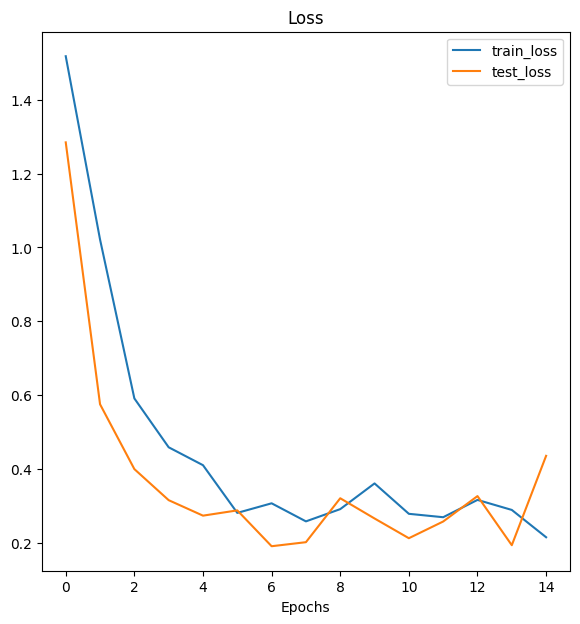

In [108]:
import matplotlib.pyplot as plt

# Get the loss values of the results dictionary (training and test)
train_loss = results['train_loss']
test_loss = results['test_loss']

# Get the accuracy values of the results dictionary (training and test)
# accuracy = results['train_acc']
# test_accuracy = results['test_acc']

# Figure out how many epochs there were
epochs = range(len(results['train_loss']))

plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='train_loss')
plt.plot(epochs, test_loss, label='test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

4. Test model with custom image

In [109]:
custom_image_path = "data/xd.jpg"

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255      # change to float32 and values range of 0-1

custom_image_transform = transforms.Compose([
    transforms.Resize(size = (224,224))
])

custom_image_transformed = custom_image_transform(custom_image)
custom_image_transformed, custom_image_transformed.shape, custom_image_transformed.dtype

(tensor([[[0.4581, 0.4581, 0.4584,  ..., 0.4198, 0.4149, 0.4395],
          [0.4660, 0.4660, 0.4661,  ..., 0.4308, 0.4298, 0.4592],
          [0.4747, 0.4747, 0.4747,  ..., 0.4416, 0.4444, 0.4802],
          ...,
          [0.2591, 0.2413, 0.2503,  ..., 0.2344, 0.2227, 0.2119],
          [0.2571, 0.2536, 0.2575,  ..., 0.4916, 0.4563, 0.4149],
          [0.2602, 0.2583, 0.2601,  ..., 0.4001, 0.4325, 0.4299]],
 
         [[0.4465, 0.4465, 0.4468,  ..., 0.4041, 0.3989, 0.4235],
          [0.4570, 0.4570, 0.4570,  ..., 0.4121, 0.4063, 0.4348],
          [0.4669, 0.4669, 0.4669,  ..., 0.4141, 0.4114, 0.4441],
          ...,
          [0.2120, 0.1942, 0.2032,  ..., 0.1389, 0.1272, 0.1164],
          [0.2100, 0.2065, 0.2105,  ..., 0.3806, 0.3453, 0.3039],
          [0.2131, 0.2112, 0.2131,  ..., 0.2767, 0.3091, 0.3065]],
 
         [[0.5156, 0.5156, 0.5159,  ..., 0.4707, 0.4657, 0.4903],
          [0.5153, 0.5153, 0.5153,  ..., 0.4798, 0.4756, 0.5045],
          [0.5187, 0.5187, 0.5187,  ...,

In [110]:
model_0.eval()
with torch.inference_mode():
    custom_image_pred = model_0(custom_image_transformed.unsqueeze(0).to(device))    

custom_image_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_label = torch.argmax(custom_image_probs, dim=1)

custom_image_probs, custom_image_label

(tensor([[0.0091, 0.6466, 0.3256, 0.0187]], device='cuda:0'),
 tensor([1], device='cuda:0'))

In [111]:
custom_image_probs.max()     # highest probability

tensor(0.6466, device='cuda:0')

In [112]:
colour = class_names[custom_image_label]    # class of the corresponding probability
colour

'blue'

Image Shape:  torch.Size([224, 224, 3])


(-0.5, 223.5, 223.5, -0.5)

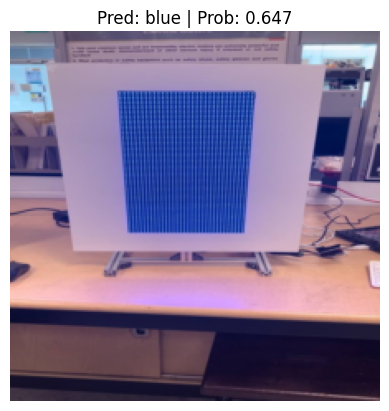

In [113]:
custom_image_transformed_permute = custom_image_transformed.permute(1, 2, 0)   # matplot only works in format of height, width, colour channels

print("Image Shape: ",custom_image_transformed_permute.shape)  # height, width, colour channels
plt.imshow(custom_image_transformed_permute)

title = f"Pred: {colour} | Prob: {custom_image_probs.max().cpu():.3f}"
plt.title(title)
plt.axis(False)

5. Save Model

In [114]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model name and path to model 
MODEL_NAME = "Simple_Model_0.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save model state dict
torch.save(obj = model_0.state_dict(),
           f = MODEL_SAVE_PATH)

6. Load Model

In [115]:
torch.manual_seed(42)
loaded_model_0 = SimpleModel_0()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_0.to(device)

SimpleModel_0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=50176, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=4, bias=True)
  )
)